<!-- ======================================
     🧩 Unmasking the Fake — Premium Styled Summary (Final)
     ====================================== -->
<div style="font-family: Inter, Segoe UI, Roboto, Arial, sans-serif; 
            line-height:1.6; 
            color:#111; 
            border:1px solid #e5e7eb; 
            border-radius:16px; 
            padding:28px; 
            box-shadow:0 6px 20px rgba(0,0,0,0.07); 
            background:linear-gradient(180deg,#ffffff 0%, #f9fafb 100%);">

  <!-- 🌈 Title with gradient background and soft hover -->
  <div style="background:linear-gradient(90deg,#7c3aed,#ec4899,#06b6d4);
              color:white;
              padding:14px 26px;
              border-radius:18px;
              box-shadow:0 3px 10px rgba(124,58,237,0.25);
              display:inline-block;
              transition:all 0.3s ease;"
       onmouseover="this.style.boxShadow='0 0 20px rgba(236,72,153,0.45)'"
       onmouseout="this.style.boxShadow='0 3px 10px rgba(124,58,237,0.25)'">
      <h2 style="margin:0; font-size:26px; letter-spacing:0.5px;">
        🧩 Unmasking the Fake with a <span style="white-space:nowrap;">CNN–DINOv2</span> Hybrid
      </h2>
  </div>

  <!-- Subtitle -->
  <p style="margin:12px 0 20px; color:#334155; font-size:15px; font-style:italic;">
    A segmentation-driven pipeline for scientific image forgery detection — combining deep embeddings and adaptive CNN decoding.
  </p>

  <!-- Overview -->
  <div style="margin:20px 0 0;">
    <h3 style="margin:8px 0; font-size:18px; border-left:4px solid #a855f7; padding-left:12px;">🧠 Overview</h3>
    <p style="margin:6px 0;">
      This solution implements a <strong>segmentation-based hybrid model</strong> that merges a <strong>self-supervised visual encoder</strong> 
      (from DINOv2) with a <strong>lightweight CNN decoder</strong>.  
      Its goal is to <em>detect</em> and <em>localize</em> image manipulations at the pixel level with high precision.
    </p>
  </div>

  <!-- Architecture -->
  <div style="margin-top:16px;">
    <h3 style="margin:8px 0; font-size:18px; border-left:4px solid #ec4899; padding-left:12px;">⚙️ Architecture</h3>
    <ol style="margin:8px 0 0 20px;">
      <li style="margin:6px 0;"><strong>Visual Encoder</strong> — extracts high-level semantic features using DINOv2 embeddings.</li>
      <li style="margin:6px 0;"><strong>CNN Decoder</strong> — converts those features into a binary segmentation mask (<code>768→256→64→1</code>).</li>
      <li style="margin:6px 0;"><strong>Resizing</strong> — all images and masks are resized to <code>256×256</code> for uniform input.</li>
    </ol>
  </div>

  <!-- Training -->
  <div style="margin-top:16px;">
    <h3 style="margin:8px 0; font-size:18px; border-left:4px solid #06b6d4; padding-left:12px;">🏋️ Training</h3>
    <ul style="margin:8px 0 0 20px;">
      <li style="margin:6px 0;"><strong>Forged images:</strong> paired with binary <code>.npy</code> masks.</li>
      <li style="margin:6px 0;"><strong>Authentic images:</strong> use empty zero masks (no manipulation).</li>
      <li style="margin:6px 0;"><strong>Loss:</strong> <code>BCEWithLogitsLoss</code> • <strong>Optimizer:</strong> <code>AdamW</code>.</li>
      <li style="margin:6px 0;">Only the CNN head is trained — the DINOv2 encoder remains frozen.</li>
    </ul>
  </div>

  <!-- Inference -->
  <div style="margin-top:16px;">
    <h3 style="margin:8px 0; font-size:18px; border-left:4px solid #f59e0b; padding-left:12px;">🔍 Inference & Post-Processing</h3>
    <ul style="margin:8px 0 0 20px;">
      <li style="margin:6px 0;">The CNN head outputs a probability map of suspicious regions.</li>
      <li style="margin:6px 0;">An <strong>adaptive refinement</strong> stage sharpens edges (Sobel gradients + Gaussian blur).</li>
      <li style="margin:6px 0;">Dynamic threshold: <code>μ + 0.3σ</code> enhances true/false separation.</li>
      <li style="margin:6px 0;">Classification rule: if <code>area &lt; 400</code> or <code>mean_inside &lt; 0.35</code> → labeled as “authentic”.</li>
    </ul>
  </div>

  <!-- Evaluation -->
  <div style="margin-top:16px;">
    <h3 style="margin:8px 0; font-size:18px; border-left:4px solid #22c55e; padding-left:12px;">📊 Evaluation</h3>
    <p style="margin:6px 0;">
      The model is evaluated on a validation subset of forged images.  
      Each predicted mask is compared with its ground truth using the <strong>F1-score</strong>.  
      The average score provides a reliable measure of segmentation performance.
    </p>
  </div>

  <!-- Key Points -->
  <div style="margin-top:16px;">
    <h3 style="margin:8px 0; font-size:18px; border-left:4px solid #3b82f6; padding-left:12px;">✅ Key Highlights</h3>
    <ul style="margin:8px 0 0 20px;">
      <li style="margin:6px 0;">Hybrid design — <strong>DINOv2</strong> (semantic understanding) + <strong>CNN</strong> (spatial precision).</li>
      <li style="margin:6px 0;">Lightweight and memory-efficient — ideal for limited GPU environments.</li>
      <li style="margin:6px 0;">Edge-aware post-processing for <strong>clean and well-defined masks</strong>.</li>
    </ul>
  </div>

 

In [ ]:
import os, cv2, json, math, random, torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from transformers import AutoImageProcessor, AutoModel

# --- 1. CONFIGURATION AND ENVIRONMENT SETUP ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories (Assuming a standard Kaggle setup)
BASE_DIR = "/kaggle/input/recodai-luc-scientific-image-forgery-detection"
AUTH_DIR = f"{BASE_DIR}/train_images/authentic"
FORG_DIR = f"{BASE_DIR}/train_images/forged"
MASK_DIR = f"{BASE_DIR}/train_masks"
TEST_DIR = f"{BASE_DIR}/test_images"
DINO_PATH = "/kaggle/input/dinov2/pytorch/base/1" # Must be pre-downloaded

# Model and Training Parameters
IMG_SIZE = 512
BATCH_SIZE = 1 # Small batch size due to high resolution/ViT features
EPOCHS_SEG = 4
LR_SEG = 1e-5
WEIGHT_DECAY = 2e-5
USE_TTA = True # Test-Time Augmentation flag

# --- 2. DATASET CLASS ---

class ForgerySegDataset(Dataset):
    def __init__(self, auth_paths, forg_paths, mask_dir, img_size=IMG_SIZE):
        self.samples = []

        # Add forged samples with masks
        for p in forg_paths:
            m = os.path.join(mask_dir, Path(p).stem + ".npy")
            if os.path.exists(m):
                self.samples.append((p, m))

        # Add authentic samples with null masks
        for p in auth_paths:
            self.samples.append((p, None))

        self.img_size = img_size

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        # Load or create mask
        if mask_path is None:
            mask = np.zeros((h, w), np.uint8)
        else:
            m = np.load(mask_path)
            if m.ndim == 3: m = np.max(m, axis=0)
            mask = (m > 0).astype(np.uint8)

        # Resize image and mask
        img_r = img.resize((self.img_size, self.img_size))
        mask_r = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        # Convert to PyTorch tensors
        img_t = torch.from_numpy(np.array(img_r, np.float32)/255.).permute(2,0,1)
        mask_t = torch.from_numpy(mask_r[None, ...].astype(np.float32))

        return img_t, mask_t


# --- 3. MODEL ARCHITECTURE (DINOv2 Encoder + CNN Decoder) ---

# Load Frozen DINOv2 Encoder
processor = AutoImageProcessor.from_pretrained(DINO_PATH, local_files_only=True)
encoder = AutoModel.from_pretrained(DINO_PATH, local_files_only=True).eval().to(device)

class DinoTinyDecoder(nn.Module):
    """Simple convolutional decoder for upsampling DINO features."""
    def __init__(self, in_ch=768, out_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, out_ch, 1)
        )

    def forward(self, f, size):
        return self.net(F.interpolate(f, size=size, mode="bilinear", align_corners=False))

class DinoSegmenter(nn.Module):
    """The full segmentation model."""
    def __init__(self, encoder, processor):
        super().__init__()
        self.encoder, self.processor = encoder, processor
        # Freeze the encoder weights
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.seg_head = DinoTinyDecoder(768, 1)

    def forward_features(self, x):
        """Passes image through DINOv2 and reshapes features into a map."""
        imgs = (x * 255).clamp(0, 255).byte().permute(0, 2, 3, 1).cpu().numpy()
        inputs = self.processor(images=list(imgs), return_tensors="pt").to(x.device)

        with torch.no_grad():
            feats = self.encoder(**inputs).last_hidden_state

        B, N, C = feats.shape
        fmap = feats[:, 1:, :].permute(0, 2, 1)
        s = int(math.sqrt(N - 1))
        fmap = fmap.reshape(B, C, s, s)
        return fmap

    def forward_seg(self, x):
        """Full segmentation forward pass."""
        fmap = self.forward_features(x)
        return self.seg_head(fmap, (IMG_SIZE, IMG_SIZE))

# --- 4. DATA SPLIT AND TRAINING ---

print(f"Starting training on device: {device}")

# Get all image paths
auth_imgs = sorted([str(Path(AUTH_DIR)/f) for f in os.listdir(AUTH_DIR)])
forg_imgs = sorted([str(Path(FORG_DIR)/f) for f in os.listdir(FORG_DIR)])

# Split data into training and validation sets
train_auth, val_auth = train_test_split(auth_imgs, test_size=0.2, random_state=42)
train_forg, val_forg = train_test_split(forg_imgs, test_size=0.2, random_state=42)

# Create DataLoader for training
train_dataset = ForgerySegDataset(train_auth, train_forg, MASK_DIR)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(f"Training on {len(train_dataset)} samples.")

# Initialize model, optimizer, and loss
model_seg = DinoSegmenter(encoder, processor).to(device)
opt_seg = optim.AdamW(model_seg.seg_head.parameters(), lr=LR_SEG, weight_decay=WEIGHT_DECAY)
crit_seg = nn.BCEWithLogitsLoss()

# Training Loop
for e in range(EPOCHS_SEG):
    model_seg.train()
    total_loss = 0
    for x, m in tqdm(train_loader, desc=f"[Segmentation] Epoch {e+1}/{EPOCHS_SEG}"):
        x, m = x.to(device), m.to(device)

        loss = crit_seg(model_seg.forward_seg(x), m)

        opt_seg.zero_grad()
        loss.backward()
        opt_seg.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"  → avg_loss={avg_loss:.4f}")

# Save final model state
torch.save(model_seg.state_dict(), "model_seg_final.pt")
print("Model saved as model_seg_final.pt")

# --- 5. INFERENCE UTILITIES AND POST-PROCESSING ---

@torch.no_grad()
def segment_prob_map(pil):
    """Generates the forgery probability map from the model."""
    x = torch.from_numpy(np.array(pil.resize((IMG_SIZE, IMG_SIZE)), np.float32)/255.).permute(2,0,1)[None].to(device)
    prob = torch.sigmoid(model_seg.forward_seg(x))[0, 0].cpu().numpy()
    return prob

def enhanced_adaptive_mask(prob, alpha_grad=0.35):
    """Refines the probability map using gradient and adaptive thresholding."""

    # Calculate gradient magnitude
    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)

    # Enhance map with gradient information
    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm
    enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # Adaptive Threshold: mean + 0.3 * std
    thr = np.mean(enhanced) + 0.3 * np.std(enhanced)
    mask = (enhanced > thr).astype(np.uint8)

    # Morphological Operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    return mask, thr

def finalize_mask(prob, orig_size):
    """Resizes the segmented mask to the original image dimensions."""
    mask, thr = enhanced_adaptive_mask(prob)
    mask = cv2.resize(mask, orig_size, interpolation=cv2.INTER_NEAREST)
    return mask, thr

def pipeline_final(pil):
    """Full inference pipeline: segmentation, refinement, and final classification."""
    if USE_TTA:
        prob = segment_prob_map_with_tta(pil)
    else:
        prob = segment_prob_map(pil)
    mask, thr = finalize_mask(prob, pil.size)

    area = int(mask.sum())

    # Calculate mean probability inside the detected mask area
    prob_resized = cv2.resize(prob, (mask.shape[1], mask.shape[0]))
    mean_inside = float(prob_resized[mask == 1].mean()) if area > 0 else 0.0

    # Final Classification/Filtering Condition
    if area < 400 or mean_inside < 0.35:
        return "authentic", None, {"area": area, "mean_inside": mean_inside, "thr": thr}

    return "forged", mask, {"area": area, "mean_inside": mean_inside, "thr": thr}

# --- 6. VALIDATION/SCORING ---

print("\n--- Validation/Scoring ---")

# Evaluate on a sample of forged images
val_items = [(p, 1) for p in val_forg[:50]]
results = []

for p, _ in tqdm(val_items, desc="Validation forged-only"):
    try:
        pil = Image.open(p).convert("RGB")

        # Get prediction
        label, m_pred, dbg = pipeline_final(pil)

        # Load ground truth mask
        m_gt = np.load(Path(MASK_DIR)/f"{Path(p).stem}.npy")
        if m_gt.ndim == 3: m_gt = np.max(m_gt, axis=0)
        m_gt = (m_gt > 0).astype(np.uint8)

        # Ensure predicted mask is a binary numpy array (zero mask if filtered)
        m_pred = (m_pred > 0).astype(np.uint8) if m_pred is not None else np.zeros_like(m_gt)

        # Calculate F1-score for segmentation
        f1 = f1_score(m_gt.flatten(), m_pred.flatten(), zero_division=0)
        results.append((Path(p).stem, f1, dbg))

    except Exception as e:
        print(f"Error processing {p}: {e}")

print("\nF1-score per forged image (Segmentation):")
for cid, f1, dbg in results:
    print(f"{cid} — F1={f1:.4f} | area={dbg['area']} mean={dbg['mean_inside']:.3f} thr={dbg['thr']:.3f}")

mean_f1 = np.mean([r[1] for r in results])
print(f"\nAverage F1 (Forged Segmentation) = {mean_f1:.4f}")

# The script ends here, as requested, without generating the final submission file.

2025-11-15 05:56:56.517922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763186216.996106      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763186217.130020      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWar

Starting training on device: cuda
Training on 4101 samples.


[Segmentation] Epoch 1/4: 100%|██████████| 4101/4101 [25:36<00:00,  2.67it/s]


  → avg_loss=0.1047


[Segmentation] Epoch 2/4: 100%|██████████| 4101/4101 [25:52<00:00,  2.64it/s]


  → avg_loss=0.0917


[Segmentation] Epoch 3/4: 100%|██████████| 4101/4101 [25:52<00:00,  2.64it/s]


  → avg_loss=0.0867


[Segmentation] Epoch 4/4: 100%|██████████| 4101/4101 [25:52<00:00,  2.64it/s]


  → avg_loss=0.0825
Model saved as model_seg_final.pt

--- Validation/Scoring ---


Validation forged-only: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


F1-score per forged image (Segmentation):
39341 — F1=0.0000 | area=10478 mean=0.165 thr=0.086
30587 — F1=0.0000 | area=291341 mean=0.014 thr=0.008
9849 — F1=0.0000 | area=2163898 mean=0.089 thr=0.044
57066 — F1=0.0000 | area=48856 mean=0.121 thr=0.058
2087 — F1=0.0000 | area=43056 mean=0.015 thr=0.012
28818 — F1=0.0000 | area=17975 mean=0.029 thr=0.017
42886 — F1=0.4773 | area=43394 mean=0.391 thr=0.168
41125 — F1=0.5548 | area=189471 mean=0.432 thr=0.170
13898 — F1=0.0000 | area=67943 mean=0.023 thr=0.014
26560 — F1=0.0000 | area=70751 mean=0.036 thr=0.022
37361 — F1=0.0000 | area=20350 mean=0.008 thr=0.006
7703 — F1=0.0000 | area=118541 mean=0.299 thr=0.083
18760 — F1=0.0000 | area=12663 mean=0.175 thr=0.060
31468 — F1=0.0000 | area=147579 mean=0.288 thr=0.095
16293 — F1=0.0000 | area=109664 mean=0.323 thr=0.100
56793 — F1=0.5377 | area=224321 mean=0.440 thr=0.181
38440 — F1=0.0000 | area=17886 mean=0.027 thr=0.016
15463 — F1=0.8526 | area=83357 mean=0.554 thr=0.230
2506 — F1=0.0000

In [ ]:
import os, cv2, json, math, random, torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from transformers import AutoImageProcessor, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR  = "/kaggle/input/recodai-luc-scientific-image-forgery-detection"
AUTH_DIR  = f"{BASE_DIR}/train_images/authentic"
FORG_DIR  = f"{BASE_DIR}/train_images/forged"
MASK_DIR  = f"{BASE_DIR}/train_masks"
TEST_DIR  = f"{BASE_DIR}/test_images"
DINO_PATH = "/kaggle/input/dinov2/pytorch/base/1"

IMG_SIZE = 512
BATCH_SIZE = 1
EPOCHS_SEG = 4
LR_SEG = 1e-5
WEIGHT_DECAY = 2e-5


class ForgerySegDataset(Dataset):
    def __init__(self, auth_paths, forg_paths, mask_dir, img_size=256):
        self.samples = []
        for p in forg_paths:
            m = os.path.join(mask_dir, Path(p).stem + ".npy")
            if os.path.exists(m):
                self.samples.append((p, m))
        for p in auth_paths:
            self.samples.append((p, None))
        self.img_size = img_size
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        if mask_path is None:
            mask = np.zeros((h, w), np.uint8)
        else:
            m = np.load(mask_path)
            if m.ndim == 3: m = np.max(m, axis=0)
            mask = (m > 0).astype(np.uint8)
        img_r = img.resize((IMG_SIZE, IMG_SIZE))
        mask_r = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        img_t = torch.from_numpy(np.array(img_r, np.float32)/255.).permute(2,0,1)
        mask_t = torch.from_numpy(mask_r[None, ...].astype(np.float32))
        return img_t, mask_t


#  MODEL (DINOv2 + Decoder)

from transformers import AutoImageProcessor, AutoModel
processor = AutoImageProcessor.from_pretrained(DINO_PATH, local_files_only=True)
encoder = AutoModel.from_pretrained(DINO_PATH, local_files_only=True).eval().to(device)

class DinoTinyDecoder(nn.Module):
    def __init__(self, in_ch=768, out_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,256,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,out_ch,1)
        )
    def forward(self, f, size):
        return self.net(F.interpolate(f, size=size, mode="bilinear", align_corners=False))

class DinoDecoder(nn.Module):
    def __init__(self, in_ch=768, out_ch=1):
        super().__init__()
        # Block 1: 768 -> 384
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        # Block 2: 384 -> 192
        self.block2 = nn.Sequential(
            nn.Conv2d(384, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        # Block 3: 192 -> 96
        self.block3 = nn.Sequential(
            nn.Conv2d(192, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Final Output: 96 -> 1
        self.conv_out = nn.Conv2d(96, out_ch, kernel_size=1)

    def forward(self, f, target_size):
        # f: [B, 768, 37, 37]

        # Step 1: Up to ~74x74
        x = F.interpolate(self.block1(f), size=(74, 74), mode='bilinear', align_corners=False)

        # Step 2: Up to ~148x148
        x = F.interpolate(self.block2(x), size=(148, 148), mode='bilinear', align_corners=False)

        # Step 3: Up to ~296x296
        x = F.interpolate(self.block3(x), size=(296, 296), mode='bilinear', align_corners=False)

        # Step 4: Final jump to 518x518
        x = self.conv_out(x)
        x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)

        return x

class DinoSegmenter(nn.Module):
    def __init__(self, encoder, processor):
        super().__init__()
        self.encoder, self.processor = encoder, processor
        for p in self.encoder.parameters(): p.requires_grad = False
        self.seg_head = DinoTinyDecoder(768,1)
    def forward_features(self,x):
        imgs = (x*255).clamp(0,255).byte().permute(0,2,3,1).cpu().numpy()
        inputs = self.processor(images=list(imgs), return_tensors="pt").to(x.device)
        with torch.no_grad(): feats = self.encoder(**inputs).last_hidden_state
        B,N,C = feats.shape
        fmap = feats[:,1:,:].permute(0,2,1)
        s = int(math.sqrt(N-1))
        fmap = fmap.reshape(B,C,s,s)
        return fmap
    def forward_seg(self,x):
        fmap = self.forward_features(x)
        return self.seg_head(fmap,(IMG_SIZE,IMG_SIZE))

#  TRAINING

auth_imgs = sorted([str(Path(AUTH_DIR)/f) for f in os.listdir(AUTH_DIR)])
forg_imgs = sorted([str(Path(FORG_DIR)/f) for f in os.listdir(FORG_DIR)])
train_auth, val_auth = train_test_split(auth_imgs, test_size=0.2, random_state=42)
train_forg, val_forg = train_test_split(forg_imgs, test_size=0.2, random_state=42)

train_loader = DataLoader(ForgerySegDataset(train_auth, train_forg, MASK_DIR),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

model_seg = DinoSegmenter(encoder, processor).to(device)
opt_seg = optim.AdamW(model_seg.seg_head.parameters(), lr=LR_SEG, weight_decay=WEIGHT_DECAY)
crit_seg = nn.BCEWithLogitsLoss()

for e in range(EPOCHS_SEG):
    model_seg.train()
    total_loss = 0
    for x,m in tqdm(train_loader, desc=f"[Segmentation] Epoch {e+1}/{EPOCHS_SEG}"):
        x,m = x.to(device),m.to(device)
        loss = crit_seg(model_seg.forward_seg(x),m)
        opt_seg.zero_grad(); loss.backward(); opt_seg.step()
        total_loss += loss.item()
    print(f"  → avg_loss={total_loss/len(train_loader):.4f}")
torch.save(model_seg.state_dict(),"model_seg_final.pt")


# INFERENCE UTILS

@torch.no_grad()
def segment_prob_map(pil):
    x = torch.from_numpy(np.array(pil.resize((IMG_SIZE, IMG_SIZE)), np.float32)/255.).permute(2,0,1)[None].to(device)
    prob = torch.sigmoid(model_seg.forward_seg(x))[0,0].cpu().numpy()
    return prob

@torch.no_grad()
def segment_prob_map_with_tta(pil):
    # 1. Preprocessing: Resize, Normalize, and move to Device
    x = torch.from_numpy(np.array(pil.resize((IMG_SIZE, IMG_SIZE)), np.float32)/255.).permute(2,0,1)[None].to(device)

    predictions = []

    # 2. Original Prediction
    pred_orig = torch.sigmoid(model_seg.forward_seg(x))
    predictions.append(pred_orig)

    # 3. Horizontal Flip TTA (dim 3)
    # Flip input -> Predict -> Flip output back
    pred_h = torch.sigmoid(model_seg.forward_seg(torch.flip(x, dims=[3])))
    predictions.append(torch.flip(pred_h, dims=[3]))

    # 4. Vertical Flip TTA (dim 2)
    # Flip input -> Predict -> Flip output back
    pred_v = torch.sigmoid(model_seg.forward_seg(torch.flip(x, dims=[2])))
    predictions.append(torch.flip(pred_v, dims=[2]))

    # 5. Average the predictions and format as numpy
    # We stack the 3 predictions and take the mean across the stack dimension (0)
    prob = torch.stack(predictions).mean(0)[0, 0].cpu().numpy()

    return prob

def enhanced_adaptive_mask(prob, alpha_grad=0.45):
    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)
    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm
    enhanced = cv2.GaussianBlur(enhanced, (3,3), 0)
    thr = np.mean(enhanced) + 0.3 * np.std(enhanced)
    mask = (enhanced > thr).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    return mask, thr

def finalize_mask(prob, orig_size):
    mask, thr = enhanced_adaptive_mask(prob)
    mask = cv2.resize(mask, orig_size, interpolation=cv2.INTER_NEAREST)
    return mask, thr

def pipeline_final(pil):
    prob = segment_prob_map(pil)
    mask, thr = finalize_mask(prob, pil.size)
    area = int(mask.sum())
    mean_inside = float(prob[cv2.resize(mask,(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_NEAREST)==1].mean()) if area>0 else 0.0
    #  condition de filtrage
    if area < 400 or mean_inside < 0.35:
        return "authentic", None, {"area": area, "mean_inside": mean_inside, "thr": thr}
    return "forged", mask, {"area": area, "mean_inside": mean_inside, "thr": thr}


from sklearn.metrics import f1_score
val_items = [(p, 1) for p in val_forg[:10]]
results = []
for p,_ in tqdm(val_items, desc="Validation forged-only"):
    pil = Image.open(p).convert("RGB")
    label, m_pred, dbg = pipeline_final(pil)
    m_gt = np.load(Path(MASK_DIR)/f"{Path(p).stem}.npy")
    if m_gt.ndim==3: m_gt=np.max(m_gt,axis=0)
    m_gt=(m_gt>0).astype(np.uint8)
    m_pred=(m_pred>0).astype(np.uint8) if m_pred is not None else np.zeros_like(m_gt)
    f1 = f1_score(m_gt.flatten(), m_pred.flatten(), zero_division=0)
    results.append((Path(p).stem, f1, dbg))
print("\n F1-score par image falsifiée:\n")
for cid,f1,dbg in results:
    print(f"{cid} — F1={f1:.4f} | area={dbg['area']} mean={dbg['mean_inside']:.3f} thr={dbg['thr']:.3f}")
print(f"\n Moyenne F1 (falsifiées) = {np.mean([r[1] for r in results]):.4f}")

[Segmentation] Epoch 1/4: 100%|██████████| 4101/4101 [25:53<00:00,  2.64it/s]


  → avg_loss=0.1050


[Segmentation] Epoch 2/4: 100%|██████████| 4101/4101 [25:54<00:00,  2.64it/s]


  → avg_loss=0.0921


[Segmentation] Epoch 3/4: 100%|██████████| 4101/4101 [25:51<00:00,  2.64it/s]


  → avg_loss=0.0870


[Segmentation] Epoch 4/4: 100%|██████████| 4101/4101 [25:54<00:00,  2.64it/s]


  → avg_loss=0.0831


Validation forged-only: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


 F1-score par image falsifiée:

39341 — F1=0.0000 | area=13304 mean=0.282 thr=0.158
30587 — F1=0.0000 | area=234763 mean=0.012 thr=0.006
9849 — F1=0.0000 | area=2416561 mean=0.086 thr=0.045
57066 — F1=0.0000 | area=54441 mean=0.097 thr=0.053
2087 — F1=0.0000 | area=36470 mean=0.014 thr=0.011
28818 — F1=0.0000 | area=15588 mean=0.015 thr=0.010
42886 — F1=0.0000 | area=54856 mean=0.344 thr=0.175
41125 — F1=0.4994 | area=163382 mean=0.353 thr=0.139
13898 — F1=0.0000 | area=60319 mean=0.018 thr=0.010
26560 — F1=0.0000 | area=65239 mean=0.029 thr=0.019

 Moyenne F1 (falsifiées) = 0.0499


Inference on Test Set: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]



✅ Saved submission file: submission.csv
  case_id annotation     area      mean       thr
0      45  authentic  1077003  0.176997  0.097395
🟢 45.png: authentic | area=0 mean=0.177


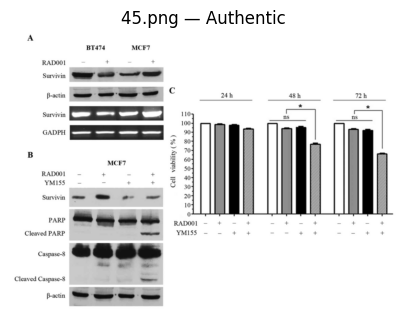

In [3]:
import os, json, cv2
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- RLE Encoder for Kaggle Submission ---
def rle_encode(mask: np.ndarray, fg_val: int = 1) -> str:
    pixels = mask.T.flatten()
    dots = np.where(pixels == fg_val)[0]
    if len(dots) == 0:
        return "authentic"
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return json.dumps([int(x) for x in run_lengths])

# --- Paths ---
TEST_DIR = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images"
SAMPLE_SUB = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv"
OUT_PATH = "submission.csv"

rows = []
for f in tqdm(sorted(os.listdir(TEST_DIR)), desc="Inference on Test Set"):
    pil = Image.open(Path(TEST_DIR)/f).convert("RGB")
    label, mask, dbg = pipeline_final(pil)  # utilise la version améliorée

    # Sécurisation masque
    if mask is None:
        mask = np.zeros(pil.size[::-1], np.uint8)
    else:
        mask = np.array(mask, dtype=np.uint8)

    # Annotation finale
    if label == "authentic":
        annot = "authentic"
    else:
        annot = rle_encode((mask > 0).astype(np.uint8))

    rows.append({
        "case_id": Path(f).stem,
        "annotation": annot,
        "area": int(dbg.get("area", mask.sum())),
        "mean": float(dbg.get("mean_inside", 0.0)),
        "thr": float(dbg.get("thr", 0.0))
    })


sub = pd.DataFrame(rows)
ss = pd.read_csv(SAMPLE_SUB)
ss["case_id"] = ss["case_id"].astype(str)
sub["case_id"] = sub["case_id"].astype(str)
final = ss[["case_id"]].merge(sub, on="case_id", how="left")
final["annotation"] = final["annotation"].fillna("authentic")
final[["case_id", "annotation"]].to_csv(OUT_PATH, index=False)

print(f"\n✅ Saved submission file: {OUT_PATH}")
print(final.head(10))


sample_files = sorted(os.listdir(TEST_DIR))[:5]
for f in sample_files:
    pil = Image.open(Path(TEST_DIR)/f).convert("RGB")
    label, mask, dbg = pipeline_final(pil)
    mask = np.array(mask, dtype=np.uint8) if mask is not None else np.zeros(pil.size[::-1], np.uint8)

    print(f"{'🔴' if label=='forged' else '🟢'} {f}: {label} | area={mask.sum()} mean={dbg.get('mean_inside', 0):.3f}")

    if label == "authentic":
        plt.figure(figsize=(5,5))
        plt.imshow(pil)
        plt.title(f"{f} — Authentic")
        plt.axis("off")
        plt.show()
    else:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil)
        plt.title("Original Image")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(pil)
        plt.imshow(mask, alpha=0.45, cmap="Reds")
        plt.title(f"Predicted Forged Mask\nArea={mask.sum()} | Mean={dbg.get('mean_inside', 0):.3f}")
        plt.axis("off")
        plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


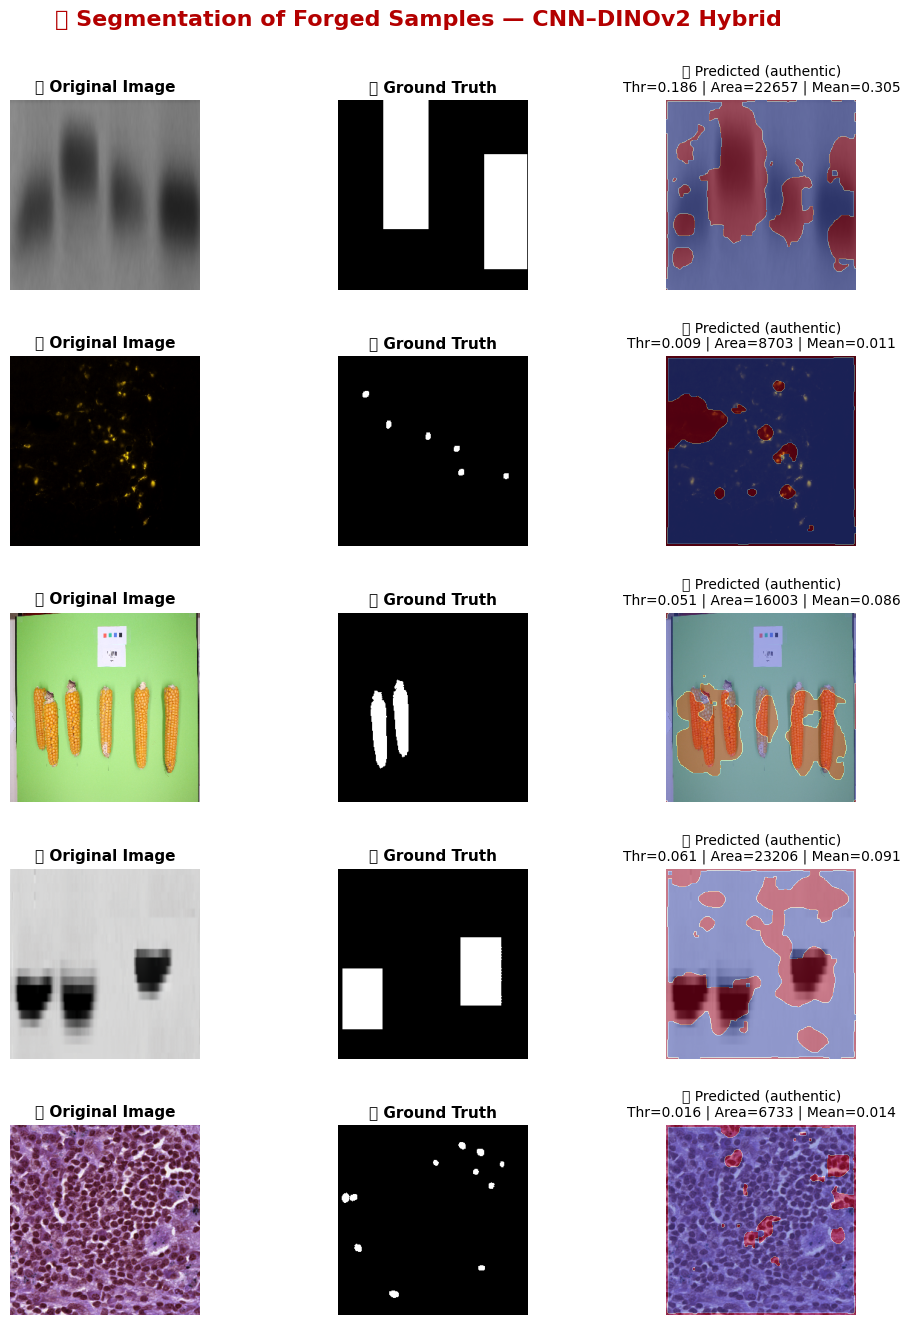

In [ ]:
import torch, cv2, math, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256

# 1️ Predict probability map (from model)
@torch.no_grad()
def predict_prob_map(pil):
    """Return DINOv2 segmentation probability map [0,1]."""
    img = pil.resize((IMG_SIZE, IMG_SIZE))
    x = torch.from_numpy(np.array(img, np.float32) / 255.).permute(2, 0, 1)[None].to(device)
    logits = model_seg.forward_seg(x)
    prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
    return prob


# 2️ Post-processing consistent with pipeline_final
def adaptive_mask(prob, alpha_grad=0.35):
    """Adaptive enhancement + morphological refinement."""
    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)

    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm
    enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)

    thr = np.mean(enhanced) + 0.3 * np.std(enhanced)
    mask = (enhanced > thr).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    return mask, float(thr)


# 3️ Unified visualization pipeline (uses same filtering logic)
def pipeline_visual(pil):
    prob = predict_prob_map(pil)
    mask, thr = adaptive_mask(prob)
    area = int(mask.sum())
    mean_inside = float(prob[mask == 1].mean()) if area > 0 else 0.0

    # same decision rule as pipeline_final
    AREA_THR, MEAN_THR = 800, 0.45
    label = "forged" if (area >= AREA_THR and mean_inside >= MEAN_THR) else "authentic"
    return label, mask, thr, area, mean_inside


# 4️ Visualization (for validation forged samples)
sample_forged = val_forg[:5]
n = len(sample_forged)
fig, axes = plt.subplots(n, 3, figsize=(12, n * 3))
if n == 1:
    axes = np.expand_dims(axes, axis=0)

for i, p in enumerate(sample_forged):
    pil = Image.open(p).convert("RGB")
    label, m_pred, thr, area, mean = pipeline_visual(pil)

    # Ground Truth mask
    m_gt = np.load(Path(MASK_DIR)/f"{Path(p).stem}.npy")
    if m_gt.ndim == 3: m_gt = np.max(m_gt, axis=0)
    m_gt = (m_gt > 0).astype(np.uint8)

    # Resize all for consistency
    img_disp = cv2.resize(np.array(pil), (256, 256))
    gt_disp  = cv2.resize(m_gt, (256, 256))
    pr_disp  = cv2.resize(m_pred, (256, 256))

    # === Column 1: Original ===
    axes[i, 0].imshow(img_disp)
    axes[i, 0].set_title("🖼️ Original Image", fontsize=11, weight="bold")
    axes[i, 0].axis("off")

    # === Column 2: Ground Truth ===
    axes[i, 1].imshow(gt_disp, cmap="gray")
    axes[i, 1].set_title("✅ Ground Truth", fontsize=11, weight="bold")
    axes[i, 1].axis("off")

    # === Column 3: Predicted Mask ===
    axes[i, 2].imshow(img_disp)
    axes[i, 2].imshow(pr_disp, cmap="coolwarm", alpha=0.45)
    axes[i, 2].set_title(f"🔮 Predicted ({label})\nThr={thr:.3f} | Area={area} | Mean={mean:.3f}",
                         fontsize=10)
    axes[i, 2].axis("off")

plt.subplots_adjust(top=0.92, hspace=0.35)
fig.suptitle("🔍 Segmentation of Forged Samples — CNN–DINOv2 Hybrid",
             fontsize=16, fontweight="bold", color="#b30000")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


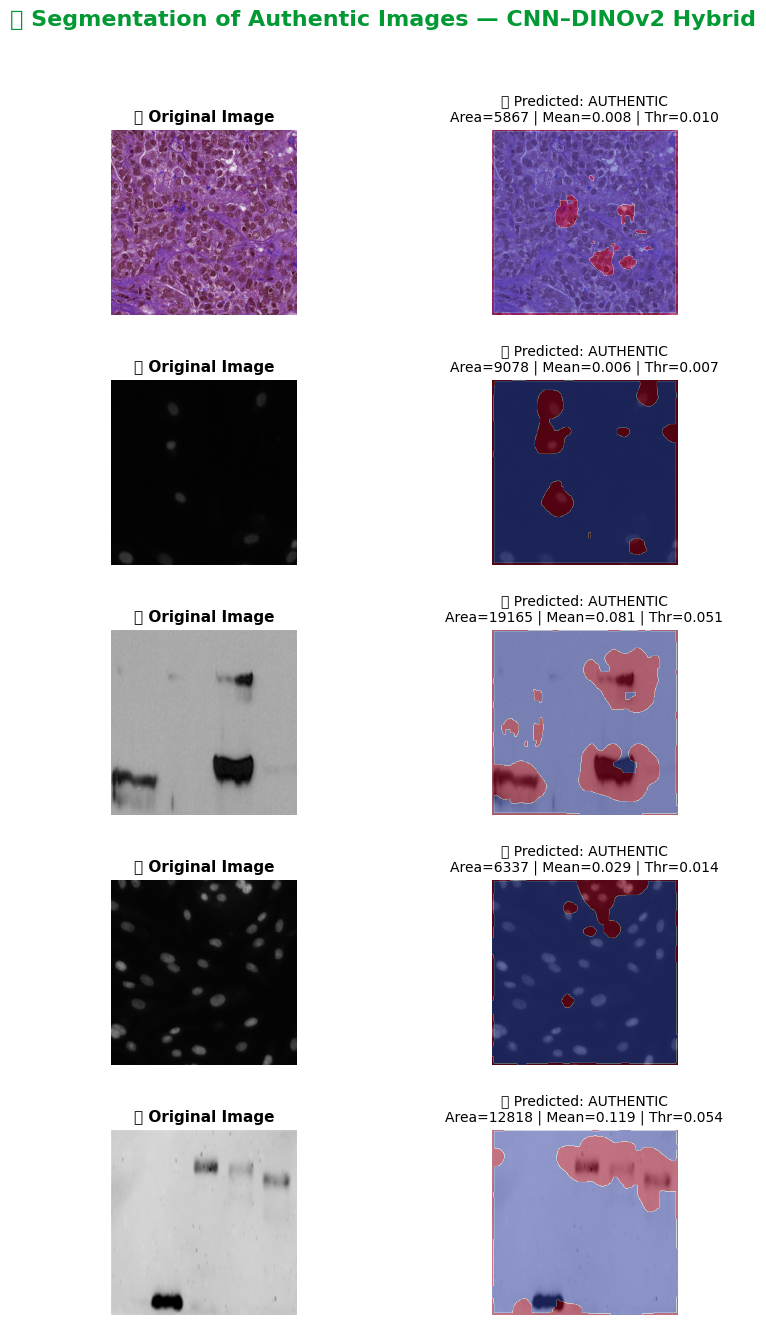

In [5]:
import matplotlib.pyplot as plt
import cv2, numpy as np
from pathlib import Path
from PIL import Image

# Select a few authentic examples
sample_auth = val_auth[:5]
n = len(sample_auth)

fig, axes = plt.subplots(n, 2, figsize=(9, n * 3))
if n == 1:
    axes = np.expand_dims(axes, axis=0)

for i, p in enumerate(sample_auth):
    pil = Image.open(p).convert("RGB")
    label, m_pred, thr, area, mean = pipeline_visual(pil)  # <-- version alignée avec ta nouvelle pipeline

    # Predicted mask (should be empty for authentic images)
    m_pred = (m_pred > 0).astype(np.uint8) if m_pred is not None else np.zeros((IMG_SIZE, IMG_SIZE))

    # Resize for consistent display
    img_disp = cv2.resize(np.array(pil), (256, 256))
    pr_disp  = cv2.resize(m_pred, (256, 256))

    # === Column 1: Original Image ===
    axes[i, 0].imshow(img_disp)
    axes[i, 0].set_title("🖼️ Original Image", fontsize=11, weight="bold")
    axes[i, 0].axis("off")

    # === Column 2: Predicted Mask ===
    axes[i, 1].imshow(img_disp)
    axes[i, 1].imshow(pr_disp, cmap="coolwarm", alpha=0.45)
    axes[i, 1].set_title(
        f"🟢 Predicted: {label.upper()}\nArea={area} | Mean={mean:.3f} | Thr={thr:.3f}",
        fontsize=10
    )
    axes[i, 1].axis("off")

    for j in range(2):
        axes[i, j].set_aspect("equal")

plt.subplots_adjust(top=0.90, hspace=0.35)
fig.suptitle("🟢 Segmentation of Authentic Images — CNN–DINOv2 Hybrid",
             fontsize=16, fontweight="bold", color="#009933")
plt.show()